In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import random as random
import csv
import heapq
from tqdm import tqdm

In [2]:
# Hyper parameters
EPISODES = 50 # times every setting is replicated
#IF_WRITEFILE = True
IF_WRITEFILE = False
RESULT_ADD = '~/'

In [15]:
# initialize parameters
R = {
        'lambda0' : 20.0, # lambdas are customer arriving rates at each block
        'lambda1' : 20.0,
        'lambda2' : 20.0,
        'lambda3' : 20.0,
        'omega' : 1.0,    # rate at waiting queue for each area
        'w_server' : 1,
        'phi' : 1.0,      # rate at fixing queue at each area
        'f_server' : 1,
        'broken' : 0.99,     # probability of a bike to be broken after each ride
        'car_move' : 1.0, # carrier moving rate among areas
       }

#queues: A0, A1, C, F, D, R00, R01, R10, R11
P = [
        [0.1, 0.4, 0.4, 0.1], 
        [0.4, 0.1, 0.1, 0.4], 
        [0.4, 0.1, 0.1, 0.4],
        [0.1, 0.4, 0.4, 0.1],
    ]

In [14]:
# theoretical distributed QN
# simulate situation with waiting and fixing
# in this version, bikes found broken after a customer RIDING


# BikeNet is the class for simulate the CQN
# simulate by discrete event, in this program called a step
# the average customer served on time is out research object


class BikeNet():
    def __init__(self, N, A, R, P, warmup_time, run_time):
        '''
        N: number of bikes in the CQN
        A: number of areas in the CQN
        R: rates of the system
        P: matrix of transit probability, including to broken
        warmup_time: the time to warm up the system
        run_time: the period of time during which get the performance
        '''
        
        self.N = N
        self.A = A
        self.R = R
        self.P = P
        self.warmup_time = warmup_time
        self.run_time = run_time
        self.time_limit = warmup_time + run_time

        self.areas = list(range(A))

        self.served_customers = 0

    def reset(self):
        self.T = 0 # time cursor to indicate the system time in this episode, at the end of every episode should be default to zero
        self.served_customers = 0 # the performance indicator
        self.W = [[] for i in range(self.A)]
        [heapq.heapify(i) for i in self.W] #time to be available for waiting queue at each area
        self.F = [[] for i in range(self.A)]
        [heapq.heapify(i) for i in self.F] #time to be available for fixing queue at each area
        # states: devide into 2 parts
        # A0, ..., AA, W0, ..., WA, F0, ..., FA: 1-d list
        # [[R00, ..., R(0,A-1)1], ..., [R(A-1,0), ..., R(A-1,A-1)]]: 2-d list for all riding queues
        #self.state = [int(self.N/self.A)]*self.A + [0]*(self.A**2+2*self.A)
        self.state1 = [int(self.N/self.A)]*self.A + [0]*2*self.A # 3 queues for each area
        self.state2 = [[0]*self.A for i in range(self.A)]
        self.scheduler = []
        heapq.heapify(self.scheduler)
        for i in range(self.A):
            # state: [time, type, start, terminal]
            # initially generate events of arriving at each area
            heapq.heappush(self.scheduler, [random.expovariate(self.R['lambda'+str(i)]), -1, i, 0])
        #return self.state + [self.T]

    def simulate(self, writefile):
        if writefile:
            with open(RESULT_ADD, 'a') as fout:
                writer = csv.writer(fout)
                self.reset()
                while self.T <= self.time_limit:
                    self.step()
                writer.writerow([self.R['lambda0'], self.N, self.served_customers / (self.T-self.warmup_time)])
        else:
            self.reset()
            while self.T <= self.time_limit:
                self.step()
            return self.served_customers / (self.T-self.warmup_time)
                
    def get_riding_time(self, s, t):
        '''
        |0|1|
        |2|3|
        '''
        if s==t: r = 0.5
        elif abs(s-t) == 2: return 2.0
        else: r = 1.0
        return random.expovariate(r)
                
        
    def add_event(self, kind, t):
        if kind == 2: 
            #print(t, len(self.W[t]))
            next_time = random.expovariate(self.R['omega'])
            next_time += self.T if self.state1[self.A+t] <= self.R['w_server'] else heapq.heappop(self.W[t])
            heapq.heappush(self.W[t], next_time)
        elif kind == 3: 
            next_time = random.expovariate(self.R['phi'])
            next_time += self.T if self.state1[2*self.A+t] <= self.R['f_server'] else heapq.heappop(self.F[t])
            heapq.heappush(self.F[t], next_time)

        heapq.heappush(self.scheduler, [next_time, kind, t, t])
        
    
    def step(self):

        event = self.scheduler[0]
        self.T, kind, start, terminal = event[0], event[1], event[2], event[3]

        '''kind:
        -1: customer ride a bike away
         1: a bike arrives
         2: a carrier arrives
         3: a bike was fixed
        '''
        if kind == 1: # 顾客骑行到达
            self.state2[start][terminal] -= 1
            if random.random()<self.R['broken']:
                self.state1[terminal+self.A] += 1
                heapq.heappop(self.scheduler)
                self.add_event(2, terminal)
            else:
                self.state1[terminal] += 1
                heapq.heappop(self.scheduler)
        elif kind == 2:
            #print('ever 2')
            self.state1[self.A+terminal] -= 1
            self.state1[self.A*2+terminal] += 1
            heapq.heappop(self.scheduler)
            self.add_event(3, terminal)
        elif kind == 3:
            #print('ever 3')
            self.state1[2*self.A+terminal] -= 1
            self.state1[terminal] += 1
            heapq.heappop(self.scheduler)
        else:# 顾客到达
            if self.state1[start] == 0:  # 但没车
                heapq.heappop(self.scheduler)
                next_time = random.expovariate(self.R['lambda'+str(start)]) + self.T
                heapq.heappush(self.scheduler, [next_time, -1, start, 0])
            else:
                if self.T>self.warmup_time: 
                    self.served_customers += 1
                    #result.append(self.served_customers / (self.T-self.warmup_time))
                # if self.T>self.warmup_time: result.append(self.T)
                
                self.state1[start] -= 1
                target = random.choices(self.areas, weights=self.P[start], k=1)[0]
                self.state2[start][target] += 1
                
                heapq.heappop(self.scheduler)
                next_time = self.get_riding_time(start, target) + self.T
                heapq.heappush(self.scheduler, [next_time, 1, start, target])
                next_time = random.expovariate(self.R['lambda'+str(start)]) + self.T
                heapq.heappush(self.scheduler, [next_time, -1, start, 0])


        #return self.state+[self.T]

random.seed(1)
N = 100  # total number of bikes in the QN
A = 4  # A for areas, indicates the number of areas and the action space


WARMUP_TIME = 2000
RUN_TIME = 5000

env = BikeNet(N=N,
              A=A,
              R=R,
              P=P,
              warmup_time=WARMUP_TIME,
              run_time=RUN_TIME)

env.simulate(IF_WRITEFILE)

# result = []
# for i in tqdm(range(1,41)):
#     env.R['carmove'] = i*0.5
#     result.append(env.simulate())
    
# plt.plot(result)
# plt.show()

4.038186947584087

In [33]:
# 单一等待队列和单一维修队列，没有redistribute的distribute的theoretical
# integrated server ruuning version
# with multiprocessing
# central no broken same lambda


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import random as random
import csv
import heapq
from tqdm import tqdm

from multiprocessing import Pool


N = 100  # total number of bikes in the QN
A = 4  # A for areas, indicates the number of areas and the action space


# initialize parameters
R = {
        'lambda0' : 20.0,
        'lambda1' : 20.0,
        'lambda2' : 20.0,
        'lambda3' : 20.0,
        'car_move': 1.0,
        'omega' : 1.0,
        'w_server' : 1,
        'phi' : 1.0,
        'f_server' : 1,
        'broken' : 0,
        'period' : 90, #the maximal time for a carrier to move among areas
       }
#queues: A0, A1, C, F, D, R00, R01, R10, R11
P = [
        [0.1, 0.4, 0.4, 0.1], 
        [0.4, 0.1, 0.1, 0.4], 
        [0.4, 0.1, 0.1, 0.4],
        [0.1, 0.4, 0.4, 0.1],
      ]

# theoretical QN
# simulate situation with collect, fix and redistribute
# in this version, bikes found broken after a customer RIDING


# BikeNet is the class for simulate the CQN
# simulate by discrete event, in this program called a step
# the average customer served on time is out research object

class BikeNet():
    
    # initiate the parameters in this function
    def __init__(self, N, A, R, P, warmup_time, run_time):
        '''
        N: number of bikes in the CQN
        A: number of areas in the CQN
        R: rates of the system
        P: matrix of transit probability, including to broken
        warmup_time: the time to warm up the system
        run_time: the period of time during which get the performance
        '''
        
        self.N = N
        self.A = A
        self.R = R
        self.P = P
        self.warmup_time = warmup_time
        self.run_time = run_time
        self.time_limit = warmup_time + run_time
#         self.edge = int(self.A**0.5)
        self.areas = list(range(A))

        self.served_customers = 0

    def reset(self):
        self.T = 0 # time cursor to indicate the system time in this episode, at the end of every episode should be default to zero
        self.served_customers = 0 # the performance indicator
        self.W = [] # time to be empty for collecting queue
        self.F = [] # time to be empty for fixing queue
        [heapq.heapify(_) for _ in [self.W, self.F]]
        # states: devide into 2 parts
        # A0, ... AA, W, F: 1-d list
        # [[R00, ..., R(0,A-1)1], ..., [R(A-1,0), ..., R(A-1,A-1)]]: 2-d list for all riding queues
        # self.state = [int(self.N/self.A)]*self.A + [0]*(self.A**2+3) # initiate the state list
        self.state1 = [int(self.N/self.A)]*self.A + [0]*2 # the last 3 numbers are for C, F, and D
        self.state2 = [[0]*self.A for i in range(self.A)]
        self.scheduler = []
        heapq.heapify(self.scheduler)
        for i in range(self.A):
            # state: [time, type, start, terminal]
            # initially generate four events of arriving at each area
            heapq.heappush(self.scheduler, [random.expovariate(self.R['lambda'+str(i)]), -1, i, 0])
        #return self.state1, self.state2, self.T

    def simulate(self, writefile):
        if writefile:
            with open(RESULT_ADD, 'a') as fout:
                writer = csv.writer(fout)
                #writer.writerow(self.R)
                #writer.writerow(self.R.values())
                #writer.writerow(self.reset())
                self.reset()
                while self.T <= self.time_limit:
                    self.step()
                writer.writerow([self.R['lambda0'], self.N, self.served_customers / (self.T-self.warmup_time)])
        else:
            self.reset()
            while self.T <= self.time_limit:
                self.step()
            return self.served_customers / (self.T-self.warmup_time)
                
    def get_riding_time(self, s, t):
        '''
        |0|1|
        |2|3|
        '''
        if s==t: r = 0.5
        elif abs(s-t) == 2: return 2.0
        else: r = 1.0
        return random.expovariate(r)

        
    def add_event(self, kind, para):
        if kind == 2: 
            next_time = random.expovariate(self.R['omega'])
            next_time += self.T if self.state1[-2] <= self.R['w_server'] else heapq.heappop(self.W)
            heapq.heappush(self.W, next_time)
            start, end = para, 'f'
        elif kind == 3: 
            next_time = random.expovariate(self.R['phi'])
            next_time += self.T if self.state1[-1] <= self.R['f_server'] else heapq.heappop(self.F)
            heapq.heappush(self.F, next_time)
            start, end = para, 'f'

        heapq.heappush(self.scheduler, [next_time, kind, start, end])
        
    
    def step(self):

        event = self.scheduler[0]
        self.T, kind, start, terminal = event[0], event[1], event[2], event[3]

        '''
        kind of events:
        -1: customer ride a bike away
         1: a bike arrives at any area
         2: a bike finishes at waiting queue
         3: a bike finishes at fixed queue
         4: a bike finishes at distributed queue
        '''
        if kind == 1: # 顾客骑行到达
            self.state2[start][terminal] -= 1
            if random.random()<self.R['broken']:
                self.state1[-2] += 1
                heapq.heappop(self.scheduler)
                self.add_event(2, start)
            else:
                self.state1[terminal] += 1
                heapq.heappop(self.scheduler)
        elif kind == 2:
            self.state1[-2] -= 1
            self.state1[-1] += 1
            heapq.heappop(self.scheduler)
            if self.state1[-2] < self.R['w_server']: heapq.heappop(self.W)
            self.add_event(3, start)
        elif kind == 3:
            self.state1[-1] -= 1
            self.state1[start] += 1
            heapq.heappop(self.scheduler)
            if self.state1[-1] < self.R['f_server']: heapq.heappop(self.F)
        else:# 顾客到达
            if self.state1[start] == 0:  # 但没车
                heapq.heappop(self.scheduler)
                next_time = random.expovariate(self.R['lambda'+str(start)]) + self.T
                heapq.heappush(self.scheduler, [next_time, -1, start, 0])
            else:
                if self.T>self.warmup_time: 
                    self.served_customers += 1
                    #result.append(self.served_customers / (self.T-self.warmup_time))
                # if self.T>self.warmup_time: result.append(self.T)
                
                self.state1[start] -= 1
                target = random.choices(self.areas, weights=self.P[start], k=1)[0]
                self.state2[start][target] += 1
                
                heapq.heappop(self.scheduler)
                next_time = self.get_riding_time(start, target) + self.T
                heapq.heappush(self.scheduler, [next_time, 1, start, target])
                next_time = random.expovariate(self.R['lambda'+str(start)]) + self.T
                heapq.heappush(self.scheduler, [next_time, -1, start, 0])


        #return self.state1, self.state2, self.T

def run(start):
    result = []
    env = BikeNet(N=N,
                  A=A,
                  R=R,
                  P=P,
                  warmup_time=WARMUP_TIME,
                  run_time=RUN_TIME)

    for b in range(start, start+25):
        env.R['broken'] = b*0.01
        result.append(env.simulate(IF_WRITEFILE, start))
    #return result
    
# Hyper parameters
EPISODES = 50 # times every setting is replicated
#IF_WRITEFILE = True
IF_WRITEFILE = False
RESULT_ADD = '/Users/valarian/SJTU/SJTU/毕业论文/Data/result/data_仿真结果/central/' + 'central_no_broken_vary_lambda.csv'

WARMUP_TIME = 2000
RUN_TIME = 5000
    
if __name__ == '__main__':

    
    p = Pool(4)
    p.map(run, [1, 26, 51, 76])

59.46029439718954
59.29905811282176


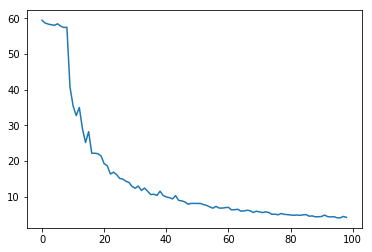

In [16]:
# influence of broken rate on distributed model

# integrated server ruuning version
# with multiprocessing
# distributed with broken

# Solution
# We set the N to be 100
# broken rate in range(0.01, 0.99, 0.01)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import random as random
import csv
import heapq
from tqdm import tqdm
import time

from multiprocessing import Pool


N = 100  # total number of bikes in the QN
A = 4  # A for areas, indicates the number of areas and the action space


# initialize parameters
R = {
        'lambda0' : 20.0, # lambdas are customer arriving rates at each block
        'lambda1' : 20.0,
        'lambda2' : 20.0,
        'lambda3' : 20.0,
        'omega' : 1.0,    # rate at waiting queue for each area
        'w_server' : 1,
        'phi' : 1.0,      # rate at fixing queue at each area
        'f_server' : 1,
        'broken' : 0.99,     # probability of a bike to be broken after each ride
        'car_move' : 1.0, # carrier moving rate among areas
       }

#queues: A0, A1, C, F, D, R00, R01, R10, R11
P = [
        [0.1, 0.4, 0.4, 0.1], 
        [0.4, 0.1, 0.1, 0.4], 
        [0.4, 0.1, 0.1, 0.4],
        [0.1, 0.4, 0.4, 0.1],
    ]

# theoretical QN
# simulate situation of distributed operation
# in this version, bikes found broken after a customer RIDING


# BikeNet is the class for simulate the CQN
# simulate by discrete event, in this program called a step
# the average customer served on time is out research object

class BikeNet():
    def __init__(self, N, A, R, P, warmup_time, run_time):
        '''
        N: number of bikes in the CQN
        A: number of areas in the CQN
        R: rates of the system
        P: matrix of transit probability, including to broken
        warmup_time: the time to warm up the system
        run_time: the period of time during which get the performance
        '''
        
        self.N = N
        self.A = A
        self.R = R
        self.P = P
        self.warmup_time = warmup_time
        self.run_time = run_time
        self.time_limit = warmup_time + run_time

        self.areas = list(range(A))

        self.served_customers = 0

    def reset(self):
        self.T = 0 # time cursor to indicate the system time in this episode, at the end of every episode should be default to zero
        self.served_customers = 0 # the performance indicator
        self.W = [[] for i in range(self.A)]
        [heapq.heapify(i) for i in self.W] #time to be available for waiting queue at each area
        self.F = [[] for i in range(self.A)]
        [heapq.heapify(i) for i in self.F] #time to be available for fixing queue at each area
        # states: devide into 2 parts
        # A0, ..., AA, W0, ..., WA, F0, ..., FA: 1-d list
        # [[R00, ..., R(0,A-1)1], ..., [R(A-1,0), ..., R(A-1,A-1)]]: 2-d list for all riding queues
        #self.state = [int(self.N/self.A)]*self.A + [0]*(self.A**2+2*self.A)
        self.state1 = [int(self.N/self.A)]*self.A + [0]*2*self.A # 3 queues for each area
        self.state2 = [[0]*self.A for i in range(self.A)]
        self.scheduler = []
        heapq.heapify(self.scheduler)
        for i in range(self.A):
            # state: [time, type, start, terminal]
            # initially generate events of arriving at each area
            heapq.heappush(self.scheduler, [random.expovariate(self.R['lambda'+str(i)]), -1, i, 0])
        #return self.state + [self.T]

    def simulate(self, writefile, start):
        if writefile:
            with open(RESULT_ADD+str(start)+'distributed_broken.csv', 'a') as fout:
                writer = csv.writer(fout)
                self.reset()
                while self.T <= self.time_limit:
                    self.step()
                writer.writerow([self.R['broken'], self.served_customers / (self.T-self.warmup_time)])
        else:
            self.reset()
            while self.T <= self.time_limit:
                self.step()
            return self.served_customers / (self.T-self.warmup_time)
                
    def get_riding_time(self, s, t):
        '''
        |0|1|
        |2|3|
        '''
        if s==t: r = 0.5
        elif abs(s-t) == 2: return 2.0
        else: r = 1.0
        return random.expovariate(r)
                
        
    def add_event(self, kind, t):
        if kind == 2: 
            #print(t, len(self.W[t]))
            next_time = random.expovariate(self.R['omega'])
            next_time += self.T if self.state1[self.A+t] <= self.R['w_server'] else heapq.heappop(self.W[t])
            heapq.heappush(self.W[t], next_time)
        elif kind == 3: 
            next_time = random.expovariate(self.R['phi'])
            next_time += self.T if self.state1[2*self.A+t] <= self.R['f_server'] else heapq.heappop(self.F[t])
            heapq.heappush(self.F[t], next_time)

        heapq.heappush(self.scheduler, [next_time, kind, t, t])
        
    
    def step(self):

        event = self.scheduler[0]
        self.T, kind, start, terminal = event[0], event[1], event[2], event[3]

        '''kind:
        -1: customer ride a bike away
         1: a bike arrives
         2: a carrier arrives
         3: a bike was fixed
        '''
        if kind == 1: # 顾客骑行到达
            self.state2[start][terminal] -= 1
            if random.random()<self.R['broken']:
                self.state1[terminal+self.A] += 1
                heapq.heappop(self.scheduler)
                self.add_event(2, terminal)
            else:
                self.state1[terminal] += 1
                heapq.heappop(self.scheduler)
        elif kind == 2:
            #print('ever 2')
            self.state1[self.A+terminal] -= 1
            self.state1[self.A*2+terminal] += 1
            heapq.heappop(self.scheduler)
            self.add_event(3, terminal)
        elif kind == 3:
            #print('ever 3')
            self.state1[2*self.A+terminal] -= 1
            self.state1[terminal] += 1
            heapq.heappop(self.scheduler)
        else:# 顾客到达
            if self.state1[start] == 0:  # 但没车
                heapq.heappop(self.scheduler)
                next_time = random.expovariate(self.R['lambda'+str(start)]) + self.T
                heapq.heappush(self.scheduler, [next_time, -1, start, 0])
            else:
                if self.T>self.warmup_time: 
                    self.served_customers += 1
                    #result.append(self.served_customers / (self.T-self.warmup_time))
                # if self.T>self.warmup_time: result.append(self.T)
                
                self.state1[start] -= 1
                target = random.choices(self.areas, weights=self.P[start], k=1)[0]
                self.state2[start][target] += 1
                
                heapq.heappop(self.scheduler)
                next_time = self.get_riding_time(start, target) + self.T
                heapq.heappush(self.scheduler, [next_time, 1, start, target])
                next_time = random.expovariate(self.R['lambda'+str(start)]) + self.T
                heapq.heappush(self.scheduler, [next_time, -1, start, 0])


        #return self.state+[self.T]

def run(start):
    #result = []
    env = BikeNet(N=N,
                  A=A,
                  R=R,
                  P=P,
                  warmup_time=WARMUP_TIME,
                  run_time=RUN_TIME)

    for b in range(start, start+25):
        env.R['broken'] = b*0.01
        env.simulate(IF_WRITEFILE, start)
    #return result
    
# Hyper parameters
EPISODES = 50 # times every setting is replicated
#IF_WRITEFILE = True
IF_WRITEFILE = False
RESULT_ADD = '/Users/valarian/SJTU/SJTU/毕业论文/Data/result/data_仿真结果/central/' + 'central_no_broken_vary_lambda.csv'

WARMUP_TIME = 2000
RUN_TIME = 5000
    
if __name__ == '__main__':

    
    p = Pool(4)
    p.map(run, [1, 26, 51, 76])
    

# Here should be another version take the redistribute effect of the distributed model into consideration

In [26]:
# take the effect of redistribution into consideration
# real QN
# in this version, carrier moves among areas to collect broken bikes
# then brings them to the repair center, and bring the normal bikes back to areas

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import random as random
import csv
import heapq
from tqdm import tqdm
import time
from multiprocessing import Pool

N = 100  # total number of bikes in the QN
A = 4  # A for areas, indicates the number of areas and the action space


# initialize parameters
R = {
        'lambda0' : 20.0,
        'lambda1' : 20.0,
        'lambda2' : 20.0,
        'lambda3' : 20.0,
        'n_carrier' : 1, #车队数
        'car_move': 1.0,
        'capacity': 12,
        'phi' : 1.0,
        'f_server' : 1, #维修人员数量
        'broken' : 0.3,
        'period' : 60, #the maximal time for a carrier to move among areas
       }
#queues: A0, A1, C, F, D, R00, R01, R10, R11
P = [
        [0.1, 0.4, 0.4, 0.1], 
        [0.4, 0.1, 0.1, 0.4], 
        [0.4, 0.1, 0.1, 0.4],
        [0.1, 0.4, 0.4, 0.1],
      ]    


class BikeNet():
    def __init__(self, N, A, R, P, warmup_time, run_time):
        self.N = N
        self.A = A
        self.R = R
        self.P = P
        self.warmup_time = warmup_time
        self.run_time = run_time
        self.time_limit = warmup_time + run_time
        self.areas = list(range(A))

        self.served_customers = 0

    def reset(self):
        self.T = 0
        self.served_customers = 0
        self.F = []*self.R['n_carrier']
        [heapq.heapify(_) for _ in self.F]
        # states: devide into 2 parts
        # A0, ... AA, B0, ..., BA, FN, FB: 1-d list
        # [[R00, ..., R(0,A-1)1], ..., [R(A-1,0), ..., R(A-1,A-1)]]: 2-d list for all riding queues
        self.state1 = [int(self.N/self.A)]*self.A + [0]*(self.A) + [[0,0] for i in range(self.R['n_carrier'])] #记录每辆运载车上的好坏车数量 
        self.state2 = [[0]*self.A for i in range(self.A)]
        #queues: A0, A1, B0, B1, FN, FB, R00, R01, R10, R11
        #self.state = [int(self.N/self.A)]*self.A + [0]*(self.A**2+2+self.A)
        self.scheduler = []
        heapq.heapify(self.scheduler)
        for i in range(self.A):
            # state: [time, type, start, terminal]
            heapq.heappush(self.scheduler, [random.expovariate(self.R['lambda'+str(i)]), -1, i, 0])
        #initiate events of the carriers, [time, kind, place, [normal, broken, time, carrier id]]
        for c in range(self.R['n_carrier']):
            heapq.heappush(self.scheduler, [0, 0, random.choice(self.areas), [0,0,self.R['period'],c]])
        #return self.state + [self.T]

    def simulate(self, writefile, start):
        if writefile:
            with open(RESULT_ADD+str(start)+'distributed_broken.csv', 'a', newline='') as fout:
                writer = csv.writer(fout)
                #writer.writerow(self.R)
                #writer.writerow(self.R.values())
                #writer.writerow(self.reset())
                self.reset()
                while self.T <= self.time_limit:
                    self.step()
                writer.writerow([start, self.R['broken'], self.served_customers / (self.T-self.warmup_time)])
        else:
            self.reset()
            while self.T <= self.time_limit:
                self.step()
            return self.served_customers / (self.T-self.warmup_time)
                
    def get_riding_time(self, s, t):
        '''
        |0|1|
        |3|2|
        '''
        if s==t: r = 0.5
        elif abs(s-t) == 2: return 2.0
        else: r = 1.0
        return random.expovariate(r)
        
    def add_event(self, kind, t):
        #self.F[t], start, end = next_time, t, t
        next_time = random.expovariate(self.R['phi']) + self.T
        #if self.state[self.A+t] == 0: self.scheduler[0][2] = (self.scheduler[0][2]+1)%4
        #the state of carrier, [time, kind, position, number of bikes carrying]
        heapq.heappush(self.scheduler, [next_time, kind, t[0], t[1]])
        
    
    def step(self):

        event = self.scheduler[0]
        self.T, kind, start, terminal = event[0], event[1], event[2], event[3]

        '''kind:
        -1: customer ride a bike away
         0: the carrier moving
         1: a bike arrives
         2: a bike was fixed
        '''
        if kind == 0:
            # 维修策略为修一个就随机去往下一个地点
            current_broken = self.state1[start+self.A]
            if current_broken>0: # 有坏车
                for i in range(min(current_broken, self.R['n_carrier'])):
                    self.add_event(2, [start, terminal])
                heapq.heappop(self.scheduler)
            else:
                self.scheduler[0][0] += random.expovariate(self.R['car_move'])
                self.scheduler[0][2] = (self.scheduler[0][2]+1)%self.A
                heapq.heapify(self.scheduler)                                                        
        elif kind == 1: # 顾客骑行到达
            self.state2[start][terminal] -= 1
            if random.random()<self.R['broken']:
                self.state1[start+self.A] += 1
                heapq.heappop(self.scheduler)
            else:
                self.state1[terminal] += 1
                heapq.heappop(self.scheduler)
        elif kind == 2:
            self.state1[self.A+start] -= 1
            self.state1[start] += 1
            heapq.heappop(self.scheduler)
            event = [self.T+random.expovariate(self.R['car_move']), 0, (start+1)%4, terminal]
            heapq.heappush(self.scheduler, event) 
        else:# 顾客到达
            if self.state1[start] == 0:  # 但没车
                heapq.heappop(self.scheduler)
                next_time = random.expovariate(self.R['lambda'+str(start)]) + self.T
                heapq.heappush(self.scheduler, [next_time, -1, start, 0])
            else:
                if self.T>self.warmup_time: 
                    self.served_customers += 1
                    #result.append(self.served_customers / (self.T-self.warmup_time))
                # if self.T>self.warmup_time: result.append(self.T)
                
                self.state1[start] -= 1
                target = random.choices(self.areas, weights=self.P[start], k=1)[0]
                self.state2[start][target] += 1
                
                heapq.heappop(self.scheduler)
                next_time = self.get_riding_time(start, target) + self.T
                heapq.heappush(self.scheduler, [next_time, 1, start, target])
                next_time = random.expovariate(self.R['lambda'+str(start)]) + self.T
                heapq.heappush(self.scheduler, [next_time, -1, start, 0])

        #return self.state+[self.T]


def run(start):
    result = []
    env = BikeNet(N=N,
                  A=A,
                  R=R,
                  P=P,
                  warmup_time=WARMUP_TIME,
                  run_time=RUN_TIME)

#     for b in range(start, start+25):
#         env.R['broken'] = b*0.01
#         result.append(env.simulate(IF_WRITEFILE, start))
    env.R['broken'] = 0.05
    result.append(env.simulate(IF_WRITEFILE, start))
    print(result)
    #return result
    
# Hyper parameters
EPISODES = 50 # times every setting is replicated
#IF_WRITEFILE = True
IF_WRITEFILE = False
RESULT_ADD = 'C:/Rebalancing/data/simulationResult/central/data/real/brokenRate/'

WARMUP_TIME = 200
RUN_TIME = 500
    
if __name__ == '__main__':

    run(1)
#     p = Pool(4)
#     p.map(run, [1, 26, 51, 76])

[9.10983338437955]


# real QN on Distributed

In [28]:
# real Q
# in this version, carrier moves among areas to collect broken bikes
# then brings them to the repair center, and bring the normal bikes back to areas

'''
To filter out the effect of redistribution, 
in the original central model, the carrier will equally redistribute repaired bikes among ares, 
however, that's absent in the distributed model,
we set the carrier will bring all the normal bikes in a area to the average level. 
'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import random as random
import csv
import heapq
from tqdm import tqdm
import time
from multiprocessing import Pool

N = 100  # total number of bikes in the QN
A = 4  # A for areas, indicates the number of areas and the action space


# initialize parameters
R = {
        'lambda0' : 20.0,
        'lambda1' : 20.0,
        'lambda2' : 20.0,
        'lambda3' : 20.0,
        'n_carrier' : 1, #车队数
        'car_move': 1.0,
        'capacity': 12,
        'phi' : 1.0,
        'f_server' : 1, #维修人员数量
        'broken' : 0.3,
        'period' : 60, #the maximal time for a carrier to move among areas
       }
#queues: A0, A1, C, F, D, R00, R01, R10, R11
P = [
        [0.1, 0.4, 0.4, 0.1], 
        [0.4, 0.1, 0.1, 0.4], 
        [0.4, 0.1, 0.1, 0.4],
        [0.1, 0.4, 0.4, 0.1],
      ]    


class BikeNet():
    def __init__(self, N, A, R, P, warmup_time, run_time):
        self.N = N
        self.A = A
        self.R = R
        self.P = P
        self.warmup_time = warmup_time
        self.run_time = run_time
        self.time_limit = warmup_time + run_time
        self.areas = list(range(A))

        self.served_customers = 0
        
        self.target_level = self.N/self.A # indicate the target level the carrier will pursue in every area

    def reset(self):
        self.T = 0
        self.served_customers = 0
        self.F = []*self.R['n_carrier']
        [heapq.heapify(_) for _ in self.F]
        # states: devide into 2 parts
        # A0, ... AA, B0, ..., BA, FN, FB: 1-d list
        # [[R00, ..., R(0,A-1)1], ..., [R(A-1,0), ..., R(A-1,A-1)]]: 2-d list for all riding queues
        self.state1 = [int(self.N/self.A)]*self.A + [0]*(self.A) + [[0,0] for i in range(self.R['n_carrier'])] #记录每辆运载车上的好坏车数量 
        self.state2 = [[0]*self.A for i in range(self.A)]
        #queues: A0, A1, B0, B1, FN, FB, R00, R01, R10, R11
        #self.state = [int(self.N/self.A)]*self.A + [0]*(self.A**2+2+self.A)
        self.scheduler = []
        heapq.heapify(self.scheduler)
        for i in range(self.A):
            # state: [time, type, start, terminal]
            heapq.heappush(self.scheduler, [random.expovariate(self.R['lambda'+str(i)]), -1, i, 0])
        #initiate events of the carriers, [time, kind, place, [normal, broken, time, carrier id]]
        for c in range(self.R['n_carrier']):
            heapq.heappush(self.scheduler, [0, 0, random.choice(self.areas), [0,0,self.R['period'],c]])
        #return self.state + [self.T]

    def simulate(self, writefile, start):
        if writefile:
            with open(RESULT_ADD+str(start)+'distributed_broken.csv', 'a', newline='') as fout:
                writer = csv.writer(fout)
                #writer.writerow(self.R)
                #writer.writerow(self.R.values())
                #writer.writerow(self.reset())
                self.reset()
                while self.T <= self.time_limit:
                    self.step()
                writer.writerow([start, self.R['broken'], self.served_customers / (self.T-self.warmup_time)])
        else:
            self.reset()
            while self.T <= self.time_limit:
                self.step()
            return self.served_customers / (self.T-self.warmup_time)
                
    def get_riding_time(self, s, t):
        '''
        |0|1|
        |3|2|
        '''
        if s==t: r = 0.5
        elif abs(s-t) == 2: return 2.0
        else: r = 1.0
        return random.expovariate(r)
        
    def add_event(self, kind, t):
        #self.F[t], start, end = next_time, t, t
        next_time = random.expovariate(self.R['phi']) + self.T
        #if self.state[self.A+t] == 0: self.scheduler[0][2] = (self.scheduler[0][2]+1)%4
        #the state of carrier, [time, kind, position, number of bikes carrying]
        heapq.heappush(self.scheduler, [next_time, kind, t[0], t[1]])
        
    
    def step(self):

        event = self.scheduler[0]
        self.T, kind, start, terminal = event[0], event[1], event[2], event[3]

        '''kind:
        -1: customer ride a bike away
         0: the carrier moving
         1: a bike arrives
         2: a bike was fixed
        '''
        if kind == 0:
            current_broken = self.state1[start+self.A]
            normal, broken, end_time, cid = terminal[0], terminal[1], terminal[2], terminal[3]
            if normal > 0 or self.state1[start]>self.target_level: #如果有好车，先把好车放下
                number = min(normal, self.target_level-self.state1[start])
                if number<0: number = max(number, self.state1[start]+self.state1[self.A+start] - self.R['capacity'])
                self.state1[start] += number #carrier所在区域好车变化
                self.scheduler[0][3][0] -= number #carrier上好车变化
                normal -= number
            if current_broken>0: # 有坏车
                for i in range(min(current_broken, self.R['n_carrier'])):
                    self.add_event(2, [start, terminal])
                heapq.heappop(self.scheduler)
            else:
                self.scheduler[0][0] += random.expovariate(self.R['car_move'])
                self.scheduler[0][2] = (self.scheduler[0][2]+1)%self.A
                heapq.heapify(self.scheduler)                                                        
        elif kind == 1: # 顾客骑行到达
            self.state2[start][terminal] -= 1
            if random.random()<self.R['broken']:
                self.state1[start+self.A] += 1
                heapq.heappop(self.scheduler)
            else:
                self.state1[terminal] += 1
                heapq.heappop(self.scheduler)
        elif kind == 2:
            self.state1[self.A+start] -= 1
            self.state1[start] += 1
            heapq.heappop(self.scheduler)
#             维修策略为修一个就随机去往下一个地点
#             event = [self.T+random.expovariate(self.R['car_move']), 0, (start+1)%4, terminal]
#             heapq.heappush(self.scheduler, event) 
            # 修完所有坏车的策略
            if self.state1[self.A+start]>0:
                self.add_event(2, [start, terminal])
            else:
                #print('ever')
                normal = terminal[0]
                if normal > 0 or self.state1[start]>self.target_level: #如果有好车，先把好车放下
                    number = min(normal, self.target_level-self.state1[start])
                    if number<0: number = max(number, self.state1[start]+self.state1[self.A+start] - self.R['capacity'])
                    self.state1[start] += number #carrier所在区域好车变化
                    terminal[0] -= number #carrier上好车变化
                    normal -= number
                event = [self.T+random.expovariate(self.R['car_move']), 0, (start+1)%4, terminal]
                heapq.heappush(self.scheduler, event)
        else:# 顾客到达
            if self.state1[start] == 0:  # 但没车
                heapq.heappop(self.scheduler)
                next_time = random.expovariate(self.R['lambda'+str(start)]) + self.T
                heapq.heappush(self.scheduler, [next_time, -1, start, 0])
            else:
                if self.T>self.warmup_time: 
                    self.served_customers += 1
                    #result.append(self.served_customers / (self.T-self.warmup_time))
                # if self.T>self.warmup_time: result.append(self.T)
                
                self.state1[start] -= 1
                target = random.choices(self.areas, weights=self.P[start], k=1)[0]
                self.state2[start][target] += 1
                
                heapq.heappop(self.scheduler)
                next_time = self.get_riding_time(start, target) + self.T
                heapq.heappush(self.scheduler, [next_time, 1, start, target])
                next_time = random.expovariate(self.R['lambda'+str(start)]) + self.T
                heapq.heappush(self.scheduler, [next_time, -1, start, 0])

        #return self.state+[self.T]


def run(start):
    result = []
    env = BikeNet(N=N,
                  A=A,
                  R=R,
                  P=P,
                  warmup_time=WARMUP_TIME,
                  run_time=RUN_TIME)

#     for b in range(start, start+25):
#         env.R['broken'] = b*0.01
#         result.append(env.simulate(IF_WRITEFILE, start))
    env.R['broken'] = 0.5
    result.append(env.simulate(IF_WRITEFILE, start))
    print(result)
    #return result
    
# Hyper parameters
EPISODES = 50 # times every setting is replicated
#IF_WRITEFILE = True
IF_WRITEFILE = False
RESULT_ADD = 'C:/Rebalancing/data/simulationResult/central/data/real/brokenRate/'

WARMUP_TIME = 200
RUN_TIME = 500
    
if __name__ == '__main__':

    run(1)
#     p = Pool(4)
#     p.map(run, [1, 26, 51, 76])

[1.9399108170519044]


# N with broken=0.3 on Distributed

In [ ]:
# influence of N and lambda rate on distributed model

# integrated server ruuning version
# with multiprocessing
# distributed with broken

# Solution
# We set the N to be 100
# broken rate in range(0.01, 0.99, 0.01)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import random as random
import csv
import heapq
from tqdm import tqdm
import time

from multiprocessing import Pool


N = 100  # total number of bikes in the QN
A = 4  # A for areas, indicates the number of areas and the action space


# initialize parameters
R = {
        'lambda0' : 20.0, # lambdas are customer arriving rates at each block
        'lambda1' : 20.0,
        'lambda2' : 20.0,
        'lambda3' : 20.0,
        'omega' : 1.0,    # rate at waiting queue for each area
        'w_server' : 1,
        'phi' : 1.0,      # rate at fixing queue at each area
        'f_server' : 1,
        'broken' : 0.3,     # probability of a bike to be broken after each ride
        'car_move' : 1.0, # carrier moving rate among areas
       }

#queues: A0, A1, C, F, D, R00, R01, R10, R11
P = [
        [0.1, 0.4, 0.4, 0.1], 
        [0.4, 0.1, 0.1, 0.4], 
        [0.4, 0.1, 0.1, 0.4],
        [0.1, 0.4, 0.4, 0.1],
    ]

# theoretical QN
# simulate situation of distributed operation
# in this version, bikes found broken after a customer RIDING


# BikeNet is the class for simulate the CQN
# simulate by discrete event, in this program called a step
# the average customer served on time is out research object

class BikeNet():
    def __init__(self, N, A, R, P, warmup_time, run_time):
        '''
        N: number of bikes in the CQN
        A: number of areas in the CQN
        R: rates of the system
        P: matrix of transit probability, including to broken
        warmup_time: the time to warm up the system
        run_time: the period of time during which get the performance
        '''
        
        self.N = N
        self.A = A
        self.R = R
        self.P = P
        self.warmup_time = warmup_time
        self.run_time = run_time
        self.time_limit = warmup_time + run_time

        self.areas = list(range(A))

        self.served_customers = 0

    def reset(self):
        self.T = 0 # time cursor to indicate the system time in this episode, at the end of every episode should be default to zero
        self.served_customers = 0 # the performance indicator
        self.W = [[] for i in range(self.A)]
        [heapq.heapify(i) for i in self.W] #time to be available for waiting queue at each area
        self.F = [[] for i in range(self.A)]
        [heapq.heapify(i) for i in self.F] #time to be available for fixing queue at each area
        # states: devide into 2 parts
        # A0, ..., AA, W0, ..., WA, F0, ..., FA: 1-d list
        # [[R00, ..., R(0,A-1)1], ..., [R(A-1,0), ..., R(A-1,A-1)]]: 2-d list for all riding queues
        #self.state = [int(self.N/self.A)]*self.A + [0]*(self.A**2+2*self.A)
        self.state1 = [int(self.N/self.A)]*self.A + [0]*2*self.A # 3 queues for each area
        self.state2 = [[0]*self.A for i in range(self.A)]
        self.scheduler = []
        heapq.heapify(self.scheduler)
        for i in range(self.A):
            # state: [time, type, start, terminal]
            # initially generate events of arriving at each area
            heapq.heappush(self.scheduler, [random.expovariate(self.R['lambda'+str(i)]), -1, i, 0])
        #return self.state + [self.T]

    def simulate(self, writefile, start):
        if writefile:
            with open(RESULT_ADD+str(start)+'distributed_broken0.3_N_lambda.csv', 'a') as fout:
                writer = csv.writer(fout)
                self.reset()
                while self.T <= self.time_limit:
                    self.step()
                writer.writerow([self.R['broken'], self.served_customers / (self.T-self.warmup_time)])
        else:
            self.reset()
            while self.T <= self.time_limit:
                self.step()
            return self.served_customers / (self.T-self.warmup_time)
                
    def get_riding_time(self, s, t):
        '''
        |0|1|
        |2|3|
        '''
        if s==t: r = 0.5
        elif abs(s-t) == 2: return 2.0
        else: r = 1.0
        return random.expovariate(r)
                
        
    def add_event(self, kind, t):
        if kind == 2: 
            #print(t, len(self.W[t]))
            next_time = random.expovariate(self.R['omega'])
            next_time += self.T if self.state1[self.A+t] <= self.R['w_server'] else heapq.heappop(self.W[t])
            heapq.heappush(self.W[t], next_time)
        elif kind == 3: 
            next_time = random.expovariate(self.R['phi'])
            next_time += self.T if self.state1[2*self.A+t] <= self.R['f_server'] else heapq.heappop(self.F[t])
            heapq.heappush(self.F[t], next_time)

        heapq.heappush(self.scheduler, [next_time, kind, t, t])
        
    
    def step(self):

        event = self.scheduler[0]
        self.T, kind, start, terminal = event[0], event[1], event[2], event[3]

        '''kind:
        -1: customer ride a bike away
         1: a bike arrives
         2: a carrier arrives
         3: a bike was fixed
        '''
        if kind == 1: # 顾客骑行到达
            self.state2[start][terminal] -= 1
            if random.random()<self.R['broken']:
                self.state1[terminal+self.A] += 1
                heapq.heappop(self.scheduler)
                self.add_event(2, terminal)
            else:
                self.state1[terminal] += 1
                heapq.heappop(self.scheduler)
        elif kind == 2:
            #print('ever 2')
            self.state1[self.A+terminal] -= 1
            self.state1[self.A*2+terminal] += 1
            heapq.heappop(self.scheduler)
            self.add_event(3, terminal)
        elif kind == 3:
            #print('ever 3')
            self.state1[2*self.A+terminal] -= 1
            self.state1[terminal] += 1
            heapq.heappop(self.scheduler)
        else:# 顾客到达
            if self.state1[start] == 0:  # 但没车
                heapq.heappop(self.scheduler)
                next_time = random.expovariate(self.R['lambda'+str(start)]) + self.T
                heapq.heappush(self.scheduler, [next_time, -1, start, 0])
            else:
                if self.T>self.warmup_time: 
                    self.served_customers += 1
                    #result.append(self.served_customers / (self.T-self.warmup_time))
                # if self.T>self.warmup_time: result.append(self.T)
                
                self.state1[start] -= 1
                target = random.choices(self.areas, weights=self.P[start], k=1)[0]
                self.state2[start][target] += 1
                
                heapq.heappop(self.scheduler)
                next_time = self.get_riding_time(start, target) + self.T
                heapq.heappush(self.scheduler, [next_time, 1, start, target])
                next_time = random.expovariate(self.R['lambda'+str(start)]) + self.T
                heapq.heappush(self.scheduler, [next_time, -1, start, 0])


        #return self.state+[self.T]

def run(start):
    env = BikeNet(N=N,
                  A=A,
                  R=R,
                  P=P,
                  warmup_time=WARMUP_TIME,
                  run_time=RUN_TIME)

    #random.seed(1)


    for r in tqdm(range(start, start+2)):
        for i in range(1, 3):
            env.R['lambda0']=env.R['lambda1']=env.R['lambda2']=env.R['lambda3'] = r
            env.N = i
            env.simulate(IF_WRITEFILE, start)
            
# Hyper parameters
IF_WRITEFILE = True
#IF_WRITEFILE = False
RESULT_ADD = 'C:/Rebalancing/data/simulationResult/central/data/BrokenN/'

WARMUP_TIME = 200
RUN_TIME = 500

if __name__ == '__main__':

    p = Pool(4)
    p.map(run, [1, 26, 51, 76]) 


# Vary lambda with broken=0.3 on Distributed

In [ ]:
# influence of varied lambda rate on distributed model

# integrated server ruuning version
# with multiprocessing
# distributed with broken

# Solution
# We set the N to be 100
# broken rate in range(0.01, 0.99, 0.01)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import random as random
import csv
import heapq
from tqdm import tqdm
import time

from multiprocessing import Pool


N = 100  # total number of bikes in the QN
A = 4  # A for areas, indicates the number of areas and the action space


# initialize parameters
R = {
        'lambda0' : 20.0, # lambdas are customer arriving rates at each block
        'lambda1' : 20.0,
        'lambda2' : 20.0,
        'lambda3' : 20.0,
        'omega' : 1.0,    # rate at waiting queue for each area
        'w_server' : 1,
        'phi' : 1.0,      # rate at fixing queue at each area
        'f_server' : 1,
        'broken' : 0.3,     # probability of a bike to be broken after each ride
        'car_move' : 1.0, # carrier moving rate among areas
       }

#queues: A0, A1, C, F, D, R00, R01, R10, R11
P = [
        [0.1, 0.4, 0.4, 0.1], 
        [0.4, 0.1, 0.1, 0.4], 
        [0.4, 0.1, 0.1, 0.4],
        [0.1, 0.4, 0.4, 0.1],
    ]

# theoretical QN
# simulate situation of distributed operation
# in this version, bikes found broken after a customer RIDING


# BikeNet is the class for simulate the CQN
# simulate by discrete event, in this program called a step
# the average customer served on time is out research object

class BikeNet():
    def __init__(self, N, A, R, P, warmup_time, run_time):
        '''
        N: number of bikes in the CQN
        A: number of areas in the CQN
        R: rates of the system
        P: matrix of transit probability, including to broken
        warmup_time: the time to warm up the system
        run_time: the period of time during which get the performance
        '''
        
        self.N = N
        self.A = A
        self.R = R
        self.P = P
        self.warmup_time = warmup_time
        self.run_time = run_time
        self.time_limit = warmup_time + run_time

        self.areas = list(range(A))

        self.served_customers = 0

    def reset(self):
        self.T = 0 # time cursor to indicate the system time in this episode, at the end of every episode should be default to zero
        self.served_customers = 0 # the performance indicator
        self.W = [[] for i in range(self.A)]
        [heapq.heapify(i) for i in self.W] #time to be available for waiting queue at each area
        self.F = [[] for i in range(self.A)]
        [heapq.heapify(i) for i in self.F] #time to be available for fixing queue at each area
        # states: devide into 2 parts
        # A0, ..., AA, W0, ..., WA, F0, ..., FA: 1-d list
        # [[R00, ..., R(0,A-1)1], ..., [R(A-1,0), ..., R(A-1,A-1)]]: 2-d list for all riding queues
        #self.state = [int(self.N/self.A)]*self.A + [0]*(self.A**2+2*self.A)
        self.state1 = [int(self.N/self.A)]*self.A + [0]*2*self.A # 3 queues for each area
        self.state2 = [[0]*self.A for i in range(self.A)]
        self.scheduler = []
        heapq.heapify(self.scheduler)
        for i in range(self.A):
            # state: [time, type, start, terminal]
            # initially generate events of arriving at each area
            heapq.heappush(self.scheduler, [random.expovariate(self.R['lambda'+str(i)]), -1, i, 0])
        #return self.state + [self.T]

    def simulate(self, writefile, start):
        if writefile:
            with open(RESULT_ADD+str(start)+'distributed_vary_lambda.csv', 'a') as fout:
                writer = csv.writer(fout)
                self.reset()
                while self.T <= self.time_limit:
                    self.step()
                writer.writerow([self.R['broken'], self.served_customers / (self.T-self.warmup_time)])
        else:
            self.reset()
            while self.T <= self.time_limit:
                self.step()
            return self.served_customers / (self.T-self.warmup_time)
                
    def get_riding_time(self, s, t):
        '''
        |0|1|
        |2|3|
        '''
        if s==t: r = 0.5
        elif abs(s-t) == 2: return 2.0
        else: r = 1.0
        return random.expovariate(r)
                
        
    def add_event(self, kind, t):
        if kind == 2: 
            #print(t, len(self.W[t]))
            next_time = random.expovariate(self.R['omega'])
            next_time += self.T if self.state1[self.A+t] <= self.R['w_server'] else heapq.heappop(self.W[t])
            heapq.heappush(self.W[t], next_time)
        elif kind == 3: 
            next_time = random.expovariate(self.R['phi'])
            next_time += self.T if self.state1[2*self.A+t] <= self.R['f_server'] else heapq.heappop(self.F[t])
            heapq.heappush(self.F[t], next_time)

        heapq.heappush(self.scheduler, [next_time, kind, t, t])
        
    
    def step(self):

        event = self.scheduler[0]
        self.T, kind, start, terminal = event[0], event[1], event[2], event[3]

        '''kind:
        -1: customer ride a bike away
         1: a bike arrives
         2: a carrier arrives
         3: a bike was fixed
        '''
        if kind == 1: # 顾客骑行到达
            self.state2[start][terminal] -= 1
            if random.random()<self.R['broken']:
                self.state1[terminal+self.A] += 1
                heapq.heappop(self.scheduler)
                self.add_event(2, terminal)
            else:
                self.state1[terminal] += 1
                heapq.heappop(self.scheduler)
        elif kind == 2:
            #print('ever 2')
            self.state1[self.A+terminal] -= 1
            self.state1[self.A*2+terminal] += 1
            heapq.heappop(self.scheduler)
            self.add_event(3, terminal)
        elif kind == 3:
            #print('ever 3')
            self.state1[2*self.A+terminal] -= 1
            self.state1[terminal] += 1
            heapq.heappop(self.scheduler)
        else:# 顾客到达
            if self.state1[start] == 0:  # 但没车
                heapq.heappop(self.scheduler)
                next_time = random.expovariate(self.R['lambda'+str(start)]) + self.T
                heapq.heappush(self.scheduler, [next_time, -1, start, 0])
            else:
                if self.T>self.warmup_time: 
                    self.served_customers += 1
                    #result.append(self.served_customers / (self.T-self.warmup_time))
                # if self.T>self.warmup_time: result.append(self.T)
                
                self.state1[start] -= 1
                target = random.choices(self.areas, weights=self.P[start], k=1)[0]
                self.state2[start][target] += 1
                
                heapq.heappop(self.scheduler)
                next_time = self.get_riding_time(start, target) + self.T
                heapq.heappush(self.scheduler, [next_time, 1, start, target])
                next_time = random.expovariate(self.R['lambda'+str(start)]) + self.T
                heapq.heappush(self.scheduler, [next_time, -1, start, 0])

def run(start):
    env = BikeNet(N=N,
                  A=A,
                  R=R,
                  P=P,
                  warmup_time=WARMUP_TIME,
                  run_time=RUN_TIME)

    for s in tqdm(range(start, start+100)):
        my_a, my_b = 0, 3*s
        for sv in [1, 2, 3]: # 1 sigma, 2 sigma, 3 sigma
            mean, stdv = s/4, s/3*sv
            env.R['sv'] = sv
            env.R['lambda0'],env.R['lambda1'],env.R['lambda2'],env.R['lambda3'] = \
                sp.stats.truncnorm.rvs((my_a-mean)/stdv, (my_b-mean)/stdv, loc=mean, scale=stdv, size=4)
            env.simulate(IF_WRITEFILE, start)
            
# Hyper parameters
IF_WRITEFILE = True
#IF_WRITEFILE = False
RESULT_ADD = 'C:/Rebalancing/data/simulationResult/distributed/data/brokenVaryLambda/'

WARMUP_TIME = 200
RUN_TIME = 500

if __name__ == '__main__':

    p = Pool(4)
    p.map(run, [201, 1, 301, 101])


# Rates with broken=0.3 on Distributed

In [ ]:
# influence of rates on distributed model

# integrated server ruuning version
# with multiprocessing
# distributed with broken

# Solution
# We set the N to be 100
# broken rate in range(0.01, 0.99, 0.01)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import random as random
import csv
import heapq
from tqdm import tqdm
import time

from multiprocessing import Pool


N = 100  # total number of bikes in the QN
A = 4  # A for areas, indicates the number of areas and the action space


# initialize parameters
R = {
        'lambda0' : 20.0, # lambdas are customer arriving rates at each block
        'lambda1' : 20.0,
        'lambda2' : 20.0,
        'lambda3' : 20.0,
        'omega' : 1.0,    # rate at waiting queue for each area
        'w_server' : 1,
        'phi' : 1.0,      # rate at fixing queue at each area
        'f_server' : 1,
        'broken' : 0.3,     # probability of a bike to be broken after each ride
        'car_move' : 1.0, # carrier moving rate among areas
       }

#queues: A0, A1, C, F, D, R00, R01, R10, R11
P = [
        [0.1, 0.4, 0.4, 0.1], 
        [0.4, 0.1, 0.1, 0.4], 
        [0.4, 0.1, 0.1, 0.4],
        [0.1, 0.4, 0.4, 0.1],
    ]

# theoretical QN
# simulate situation of distributed operation
# in this version, bikes found broken after a customer RIDING


# BikeNet is the class for simulate the CQN
# simulate by discrete event, in this program called a step
# the average customer served on time is out research object

class BikeNet():
    def __init__(self, N, A, R, P, warmup_time, run_time):
        '''
        N: number of bikes in the CQN
        A: number of areas in the CQN
        R: rates of the system
        P: matrix of transit probability, including to broken
        warmup_time: the time to warm up the system
        run_time: the period of time during which get the performance
        '''
        
        self.N = N
        self.A = A
        self.R = R
        self.P = P
        self.warmup_time = warmup_time
        self.run_time = run_time
        self.time_limit = warmup_time + run_time

        self.areas = list(range(A))

        self.served_customers = 0

    def reset(self):
        self.T = 0 # time cursor to indicate the system time in this episode, at the end of every episode should be default to zero
        self.served_customers = 0 # the performance indicator
        self.W = [[] for i in range(self.A)]
        [heapq.heapify(i) for i in self.W] #time to be available for waiting queue at each area
        self.F = [[] for i in range(self.A)]
        [heapq.heapify(i) for i in self.F] #time to be available for fixing queue at each area
        # states: devide into 2 parts
        # A0, ..., AA, W0, ..., WA, F0, ..., FA: 1-d list
        # [[R00, ..., R(0,A-1)1], ..., [R(A-1,0), ..., R(A-1,A-1)]]: 2-d list for all riding queues
        #self.state = [int(self.N/self.A)]*self.A + [0]*(self.A**2+2*self.A)
        self.state1 = [int(self.N/self.A)]*self.A + [0]*2*self.A # 3 queues for each area
        self.state2 = [[0]*self.A for i in range(self.A)]
        self.scheduler = []
        heapq.heapify(self.scheduler)
        for i in range(self.A):
            # state: [time, type, start, terminal]
            # initially generate events of arriving at each area
            heapq.heappush(self.scheduler, [random.expovariate(self.R['lambda'+str(i)]), -1, i, 0])
        #return self.state + [self.T]

    def simulate(self, writefile, start):
        if writefile:
            with open(RESULT_ADD+str(start)+'distributed_rates.csv', 'a') as fout:
                writer = csv.writer(fout)
                self.reset()
                while self.T <= self.time_limit:
                    self.step()
                writer.writerow([start_index, self.R['c_server'], self.R['gamma'],self.R['f_server'],self.R['phi'],self.R['d_server'],self.R['delta'], self.served_customers / (self.T-self.warmup_time)])
        else:
            self.reset()
            while self.T <= self.time_limit:
                self.step()
            return self.served_customers / (self.T-self.warmup_time)
                
    def get_riding_time(self, s, t):
        '''
        |0|1|
        |2|3|
        '''
        if s==t: r = 0.5
        elif abs(s-t) == 2: return 2.0
        else: r = 1.0
        return random.expovariate(r)
                
        
    def add_event(self, kind, t):
        if kind == 2: 
            #print(t, len(self.W[t]))
            next_time = random.expovariate(self.R['omega'])
            next_time += self.T if self.state1[self.A+t] <= self.R['w_server'] else heapq.heappop(self.W[t])
            heapq.heappush(self.W[t], next_time)
        elif kind == 3: 
            next_time = random.expovariate(self.R['phi'])
            next_time += self.T if self.state1[2*self.A+t] <= self.R['f_server'] else heapq.heappop(self.F[t])
            heapq.heappush(self.F[t], next_time)

        heapq.heappush(self.scheduler, [next_time, kind, t, t])
        
    
    def step(self):

        event = self.scheduler[0]
        self.T, kind, start, terminal = event[0], event[1], event[2], event[3]

        '''kind:
        -1: customer ride a bike away
         1: a bike arrives
         2: a carrier arrives
         3: a bike was fixed
        '''
        if kind == 1: # 顾客骑行到达
            self.state2[start][terminal] -= 1
            if random.random()<self.R['broken']:
                self.state1[terminal+self.A] += 1
                heapq.heappop(self.scheduler)
                self.add_event(2, terminal)
            else:
                self.state1[terminal] += 1
                heapq.heappop(self.scheduler)
        elif kind == 2:
            #print('ever 2')
            self.state1[self.A+terminal] -= 1
            self.state1[self.A*2+terminal] += 1
            heapq.heappop(self.scheduler)
            self.add_event(3, terminal)
        elif kind == 3:
            #print('ever 3')
            self.state1[2*self.A+terminal] -= 1
            self.state1[terminal] += 1
            heapq.heappop(self.scheduler)
        else:# 顾客到达
            if self.state1[start] == 0:  # 但没车
                heapq.heappop(self.scheduler)
                next_time = random.expovariate(self.R['lambda'+str(start)]) + self.T
                heapq.heappush(self.scheduler, [next_time, -1, start, 0])
            else:
                if self.T>self.warmup_time: 
                    self.served_customers += 1
                    #result.append(self.served_customers / (self.T-self.warmup_time))
                # if self.T>self.warmup_time: result.append(self.T)
                
                self.state1[start] -= 1
                target = random.choices(self.areas, weights=self.P[start], k=1)[0]
                self.state2[start][target] += 1
                
                heapq.heappop(self.scheduler)
                next_time = self.get_riding_time(start, target) + self.T
                heapq.heappush(self.scheduler, [next_time, 1, start, target])
                next_time = random.expovariate(self.R['lambda'+str(start)]) + self.T
                heapq.heappush(self.scheduler, [next_time, -1, start, 0])

def run(start):
    env = BikeNet(N=N,
                  A=A,
                  R=R,
                  P=P,
                  warmup_time=WARMUP_TIME,
                  run_time=RUN_TIME)
    env.R['c_server'] = start
#     for c in tqdm(range(5, 21, 5)):
#         for fs in range(1, 6):
#             for f in range(5, 21, 5):
#                 for ds in range(1, 6):
#                     for d in range(5, 21, 5):
    for c in tqdm(range(5, 11, 5)):
        for fs in range(1, 3):
            for f in range(5, 11, 5):
                for ds in range(1, 1):
                    for d in range(5, 6, 5):
                        env.R['gamma'],env.R['f_server'],env.R['phi'],env.R['d_server'],env.R['delta'] = \
                            c, fs, f, ds, d
                        env.simulate(IF_WRITEFILE, start)
            
# Hyper parameters
IF_WRITEFILE = True
#IF_WRITEFILE = False
RESULT_ADD = 'C:/Rebalancing/data/simulationResult/distributed/data/brokenVaryRates/'

WARMUP_TIME = 200
RUN_TIME = 500

if __name__ == '__main__':

    p = Pool(4)
    p.map(run, [1,2,3,4])